## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 8

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:01<00:00, 95633198.34it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch16-768d-8h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch16-768d-8h-12l_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]


Epoch : 1 - acc: 0.0619 - loss : 4.2218



100%|██████████| 313/313 [00:03<00:00, 87.40it/s]


test acc: 0.0942 - test loss : 3.9430



100%|██████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch : 2 - acc: 0.1069 - loss : 3.8817



100%|██████████| 313/313 [00:03<00:00, 86.20it/s]


test acc: 0.1280 - test loss : 3.7786



100%|██████████| 1563/1563 [01:02<00:00, 24.88it/s]


Epoch : 3 - acc: 0.1268 - loss : 3.7440



100%|██████████| 313/313 [00:03<00:00, 82.60it/s]


test acc: 0.1408 - test loss : 3.6653



100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


Epoch : 4 - acc: 0.1438 - loss : 3.6421



100%|██████████| 313/313 [00:03<00:00, 82.78it/s]


test acc: 0.1682 - test loss : 3.5299



100%|██████████| 1563/1563 [01:03<00:00, 24.69it/s]


Epoch : 5 - acc: 0.1598 - loss : 3.5440



100%|██████████| 313/313 [00:03<00:00, 80.43it/s]


test acc: 0.1676 - test loss : 3.5091



100%|██████████| 1563/1563 [01:04<00:00, 24.19it/s]


Epoch : 6 - acc: 0.1711 - loss : 3.4723



100%|██████████| 313/313 [00:03<00:00, 84.61it/s]


test acc: 0.1817 - test loss : 3.4312



100%|██████████| 1563/1563 [01:03<00:00, 24.49it/s]


Epoch : 7 - acc: 0.1850 - loss : 3.3980



100%|██████████| 313/313 [00:03<00:00, 86.58it/s]


test acc: 0.1937 - test loss : 3.3551



100%|██████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch : 8 - acc: 0.1917 - loss : 3.3470



100%|██████████| 313/313 [00:03<00:00, 86.33it/s]


test acc: 0.2068 - test loss : 3.3015



100%|██████████| 1563/1563 [01:05<00:00, 23.81it/s]


Epoch : 9 - acc: 0.2010 - loss : 3.2941



100%|██████████| 313/313 [00:03<00:00, 84.71it/s]


test acc: 0.2136 - test loss : 3.2538



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 10 - acc: 0.2073 - loss : 3.2525



100%|██████████| 313/313 [00:03<00:00, 84.13it/s]


test acc: 0.2122 - test loss : 3.2740



100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


Epoch : 11 - acc: 0.2177 - loss : 3.2091



100%|██████████| 313/313 [00:03<00:00, 82.46it/s]


test acc: 0.2142 - test loss : 3.2272



100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s]


Epoch : 12 - acc: 0.2239 - loss : 3.1658



100%|██████████| 313/313 [00:03<00:00, 82.81it/s]


test acc: 0.2393 - test loss : 3.1716



100%|██████████| 1563/1563 [01:04<00:00, 24.20it/s]


Epoch : 13 - acc: 0.2299 - loss : 3.1311



100%|██████████| 313/313 [00:03<00:00, 81.72it/s]


test acc: 0.2390 - test loss : 3.1651



100%|██████████| 1563/1563 [01:05<00:00, 23.93it/s]


Epoch : 14 - acc: 0.2362 - loss : 3.0992



100%|██████████| 313/313 [00:03<00:00, 78.41it/s]


test acc: 0.2438 - test loss : 3.1200



100%|██████████| 1563/1563 [01:04<00:00, 24.23it/s]


Epoch : 15 - acc: 0.2429 - loss : 3.0621



100%|██████████| 313/313 [00:03<00:00, 80.89it/s]


test acc: 0.2494 - test loss : 3.1061



100%|██████████| 1563/1563 [01:04<00:00, 24.10it/s]


Epoch : 16 - acc: 0.2495 - loss : 3.0221



100%|██████████| 313/313 [00:03<00:00, 84.66it/s]


test acc: 0.2423 - test loss : 3.1090



100%|██████████| 1563/1563 [01:04<00:00, 24.06it/s]


Epoch : 17 - acc: 0.2537 - loss : 3.0038



100%|██████████| 313/313 [00:03<00:00, 82.16it/s]


test acc: 0.2523 - test loss : 3.0904



100%|██████████| 1563/1563 [01:04<00:00, 24.10it/s]


Epoch : 18 - acc: 0.2580 - loss : 2.9708



100%|██████████| 313/313 [00:03<00:00, 79.54it/s]


test acc: 0.2634 - test loss : 3.0572



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 19 - acc: 0.2680 - loss : 2.9310



100%|██████████| 313/313 [00:04<00:00, 77.85it/s]


test acc: 0.2553 - test loss : 3.0531



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 20 - acc: 0.2686 - loss : 2.9162



100%|██████████| 313/313 [00:03<00:00, 85.95it/s]


test acc: 0.2623 - test loss : 3.0405



100%|██████████| 1563/1563 [01:04<00:00, 24.34it/s]


Epoch : 21 - acc: 0.2747 - loss : 2.8853



100%|██████████| 313/313 [00:04<00:00, 75.20it/s]


test acc: 0.2647 - test loss : 3.0361



100%|██████████| 1563/1563 [01:03<00:00, 24.42it/s]


Epoch : 22 - acc: 0.2811 - loss : 2.8590



100%|██████████| 313/313 [00:03<00:00, 81.37it/s]


test acc: 0.2679 - test loss : 3.0255



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 23 - acc: 0.2831 - loss : 2.8388



100%|██████████| 313/313 [00:03<00:00, 82.30it/s]


test acc: 0.2762 - test loss : 2.9863



100%|██████████| 1563/1563 [01:03<00:00, 24.68it/s]


Epoch : 24 - acc: 0.2887 - loss : 2.8138



100%|██████████| 313/313 [00:03<00:00, 86.68it/s]


test acc: 0.2758 - test loss : 2.9830



100%|██████████| 1563/1563 [01:04<00:00, 24.09it/s]


Epoch : 25 - acc: 0.2944 - loss : 2.7877



100%|██████████| 313/313 [00:03<00:00, 87.87it/s]


test acc: 0.2766 - test loss : 2.9827



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 26 - acc: 0.2975 - loss : 2.7697



100%|██████████| 313/313 [00:04<00:00, 77.05it/s]


test acc: 0.2769 - test loss : 2.9675



100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


Epoch : 27 - acc: 0.3026 - loss : 2.7434



100%|██████████| 313/313 [00:03<00:00, 83.63it/s]


test acc: 0.2830 - test loss : 2.9590



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 28 - acc: 0.3049 - loss : 2.7206



100%|██████████| 313/313 [00:04<00:00, 77.85it/s]


test acc: 0.2794 - test loss : 2.9845



100%|██████████| 1563/1563 [01:04<00:00, 24.24it/s]


Epoch : 29 - acc: 0.3125 - loss : 2.6919



100%|██████████| 313/313 [00:03<00:00, 84.13it/s]


test acc: 0.2857 - test loss : 2.9778



100%|██████████| 1563/1563 [01:04<00:00, 24.25it/s]


Epoch : 30 - acc: 0.3167 - loss : 2.6684



100%|██████████| 313/313 [00:03<00:00, 83.45it/s]


test acc: 0.2835 - test loss : 2.9462



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 31 - acc: 0.3180 - loss : 2.6542



100%|██████████| 313/313 [00:03<00:00, 81.55it/s]


test acc: 0.2849 - test loss : 2.9500



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 32 - acc: 0.3259 - loss : 2.6290



100%|██████████| 313/313 [00:03<00:00, 84.66it/s]


test acc: 0.2859 - test loss : 2.9585



100%|██████████| 1563/1563 [01:03<00:00, 24.44it/s]


Epoch : 33 - acc: 0.3299 - loss : 2.6046



100%|██████████| 313/313 [00:03<00:00, 81.39it/s]


test acc: 0.2959 - test loss : 2.9164



100%|██████████| 1563/1563 [01:04<00:00, 24.30it/s]


Epoch : 34 - acc: 0.3325 - loss : 2.5816



100%|██████████| 313/313 [00:03<00:00, 88.17it/s]


test acc: 0.2914 - test loss : 2.9368



100%|██████████| 1563/1563 [01:04<00:00, 24.39it/s]


Epoch : 35 - acc: 0.3388 - loss : 2.5591



100%|██████████| 313/313 [00:03<00:00, 83.92it/s]


test acc: 0.2920 - test loss : 2.9511



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 36 - acc: 0.3420 - loss : 2.5387



100%|██████████| 313/313 [00:04<00:00, 72.20it/s]


test acc: 0.2911 - test loss : 2.9358



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 37 - acc: 0.3499 - loss : 2.5159



100%|██████████| 313/313 [00:03<00:00, 82.08it/s]


test acc: 0.2961 - test loss : 2.9257



100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s]


Epoch : 38 - acc: 0.3517 - loss : 2.4931



100%|██████████| 313/313 [00:03<00:00, 83.39it/s]


test acc: 0.2950 - test loss : 2.9178



100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s]


Epoch : 39 - acc: 0.3531 - loss : 2.4824



100%|██████████| 313/313 [00:03<00:00, 82.20it/s]


test acc: 0.2992 - test loss : 2.9229



100%|██████████| 1563/1563 [01:03<00:00, 24.48it/s]


Epoch : 40 - acc: 0.3601 - loss : 2.4521



100%|██████████| 313/313 [00:03<00:00, 83.61it/s]


test acc: 0.3010 - test loss : 2.9171



100%|██████████| 1563/1563 [01:04<00:00, 24.11it/s]


Epoch : 41 - acc: 0.3652 - loss : 2.4350



100%|██████████| 313/313 [00:03<00:00, 83.22it/s]


test acc: 0.3040 - test loss : 2.9163



100%|██████████| 1563/1563 [01:04<00:00, 24.20it/s]


Epoch : 42 - acc: 0.3691 - loss : 2.4062



100%|██████████| 313/313 [00:03<00:00, 79.96it/s]


test acc: 0.2984 - test loss : 2.9342



100%|██████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch : 43 - acc: 0.3717 - loss : 2.3926



100%|██████████| 313/313 [00:03<00:00, 79.83it/s]


test acc: 0.3019 - test loss : 2.9390



100%|██████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch : 44 - acc: 0.3768 - loss : 2.3705



100%|██████████| 313/313 [00:03<00:00, 88.14it/s]


test acc: 0.3078 - test loss : 2.9142



100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 45 - acc: 0.3807 - loss : 2.3450



100%|██████████| 313/313 [00:03<00:00, 81.07it/s]


test acc: 0.3050 - test loss : 2.9103



100%|██████████| 1563/1563 [01:04<00:00, 24.34it/s]


Epoch : 46 - acc: 0.3851 - loss : 2.3313



100%|██████████| 313/313 [00:03<00:00, 91.82it/s]


test acc: 0.3030 - test loss : 2.9186



100%|██████████| 1563/1563 [01:03<00:00, 24.54it/s]


Epoch : 47 - acc: 0.3899 - loss : 2.3056



100%|██████████| 313/313 [00:03<00:00, 83.80it/s]


test acc: 0.3009 - test loss : 2.9483



100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s]


Epoch : 48 - acc: 0.3943 - loss : 2.2935



100%|██████████| 313/313 [00:03<00:00, 78.80it/s]


test acc: 0.3059 - test loss : 2.9502



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 49 - acc: 0.3944 - loss : 2.2718



100%|██████████| 313/313 [00:03<00:00, 88.40it/s]


test acc: 0.3097 - test loss : 2.9181



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 50 - acc: 0.4001 - loss : 2.2515



100%|██████████| 313/313 [00:03<00:00, 87.09it/s]


test acc: 0.3117 - test loss : 2.9148



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 51 - acc: 0.4024 - loss : 2.2387



100%|██████████| 313/313 [00:03<00:00, 82.41it/s]


test acc: 0.3106 - test loss : 2.9286



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 52 - acc: 0.4100 - loss : 2.2078



100%|██████████| 313/313 [00:03<00:00, 89.48it/s]


test acc: 0.3029 - test loss : 2.9645



100%|██████████| 1563/1563 [01:04<00:00, 24.15it/s]


Epoch : 53 - acc: 0.4145 - loss : 2.1957



100%|██████████| 313/313 [00:03<00:00, 86.27it/s]


test acc: 0.3095 - test loss : 2.9405



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 54 - acc: 0.4155 - loss : 2.1801



100%|██████████| 313/313 [00:03<00:00, 83.07it/s]


test acc: 0.3096 - test loss : 2.9445



100%|██████████| 1563/1563 [01:05<00:00, 23.99it/s]


Epoch : 55 - acc: 0.4211 - loss : 2.1648



100%|██████████| 313/313 [00:03<00:00, 81.52it/s]


test acc: 0.3092 - test loss : 2.9588



100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch : 56 - acc: 0.4233 - loss : 2.1407



100%|██████████| 313/313 [00:03<00:00, 93.00it/s] 


test acc: 0.3103 - test loss : 2.9788



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 57 - acc: 0.4292 - loss : 2.1147



100%|██████████| 313/313 [00:03<00:00, 87.72it/s]


test acc: 0.3188 - test loss : 2.9625



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 58 - acc: 0.4317 - loss : 2.0983



100%|██████████| 313/313 [00:03<00:00, 84.11it/s]


test acc: 0.3094 - test loss : 3.0046



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 59 - acc: 0.4367 - loss : 2.0784



100%|██████████| 313/313 [00:03<00:00, 88.86it/s]


test acc: 0.3152 - test loss : 2.9849



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 60 - acc: 0.4418 - loss : 2.0550



100%|██████████| 313/313 [00:03<00:00, 87.37it/s]


test acc: 0.3112 - test loss : 2.9591



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 61 - acc: 0.4434 - loss : 2.0493



100%|██████████| 313/313 [00:03<00:00, 87.23it/s]


test acc: 0.3166 - test loss : 2.9678



100%|██████████| 1563/1563 [01:03<00:00, 24.43it/s]


Epoch : 62 - acc: 0.4474 - loss : 2.0303



100%|██████████| 313/313 [00:03<00:00, 89.02it/s]


test acc: 0.3147 - test loss : 2.9929



100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s]


Epoch : 63 - acc: 0.4489 - loss : 2.0149



100%|██████████| 313/313 [00:03<00:00, 82.46it/s]


test acc: 0.3171 - test loss : 2.9983



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 64 - acc: 0.4567 - loss : 1.9855



100%|██████████| 313/313 [00:04<00:00, 75.16it/s]


test acc: 0.3173 - test loss : 3.0169



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 65 - acc: 0.4627 - loss : 1.9566



100%|██████████| 313/313 [00:03<00:00, 84.98it/s]


test acc: 0.3128 - test loss : 3.0401



100%|██████████| 1563/1563 [01:04<00:00, 24.37it/s]


Epoch : 66 - acc: 0.4654 - loss : 1.9398



100%|██████████| 313/313 [00:03<00:00, 93.33it/s]


test acc: 0.3125 - test loss : 3.0529



100%|██████████| 1563/1563 [01:05<00:00, 23.74it/s]


Epoch : 67 - acc: 0.4685 - loss : 1.9266



100%|██████████| 313/313 [00:03<00:00, 79.55it/s]


test acc: 0.3130 - test loss : 3.0424



100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s]


Epoch : 68 - acc: 0.4754 - loss : 1.9055



100%|██████████| 313/313 [00:03<00:00, 84.12it/s]


test acc: 0.3117 - test loss : 3.0762



100%|██████████| 1563/1563 [01:03<00:00, 24.76it/s]


Epoch : 69 - acc: 0.4729 - loss : 1.8952



100%|██████████| 313/313 [00:03<00:00, 82.95it/s]


test acc: 0.3151 - test loss : 3.0617



100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Epoch : 70 - acc: 0.4807 - loss : 1.8734



100%|██████████| 313/313 [00:03<00:00, 87.09it/s]


test acc: 0.3115 - test loss : 3.0672



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 71 - acc: 0.4867 - loss : 1.8550



100%|██████████| 313/313 [00:03<00:00, 85.69it/s]


test acc: 0.3139 - test loss : 3.1044



100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


Epoch : 72 - acc: 0.4924 - loss : 1.8321



100%|██████████| 313/313 [00:03<00:00, 89.94it/s] 


test acc: 0.3195 - test loss : 3.1323



100%|██████████| 1563/1563 [01:04<00:00, 24.41it/s]


Epoch : 73 - acc: 0.4958 - loss : 1.8111



100%|██████████| 313/313 [00:03<00:00, 87.78it/s]


test acc: 0.3171 - test loss : 3.1169



100%|██████████| 1563/1563 [01:03<00:00, 24.47it/s]


Epoch : 74 - acc: 0.4992 - loss : 1.7927



100%|██████████| 313/313 [00:03<00:00, 85.32it/s] 


test acc: 0.3187 - test loss : 3.1107



100%|██████████| 1563/1563 [01:03<00:00, 24.62it/s]


Epoch : 75 - acc: 0.5032 - loss : 1.7758



100%|██████████| 313/313 [00:03<00:00, 85.30it/s]


test acc: 0.3111 - test loss : 3.1124



100%|██████████| 1563/1563 [01:02<00:00, 24.87it/s]


Epoch : 76 - acc: 0.5118 - loss : 1.7439



100%|██████████| 313/313 [00:03<00:00, 80.17it/s]


test acc: 0.3150 - test loss : 3.1412



100%|██████████| 1563/1563 [01:02<00:00, 24.84it/s]


Epoch : 77 - acc: 0.5143 - loss : 1.7289



100%|██████████| 313/313 [00:04<00:00, 71.54it/s]


test acc: 0.3169 - test loss : 3.1493



100%|██████████| 1563/1563 [01:05<00:00, 23.87it/s]


Epoch : 78 - acc: 0.5184 - loss : 1.7124



100%|██████████| 313/313 [00:03<00:00, 89.87it/s]


test acc: 0.3176 - test loss : 3.1866



100%|██████████| 1563/1563 [01:05<00:00, 23.95it/s]


Epoch : 79 - acc: 0.5225 - loss : 1.6915



100%|██████████| 313/313 [00:03<00:00, 85.13it/s]


test acc: 0.3184 - test loss : 3.1537



100%|██████████| 1563/1563 [01:03<00:00, 24.71it/s]


Epoch : 80 - acc: 0.5285 - loss : 1.6720



100%|██████████| 313/313 [00:03<00:00, 86.18it/s]


test acc: 0.3145 - test loss : 3.2172



100%|██████████| 1563/1563 [01:03<00:00, 24.75it/s]


Epoch : 81 - acc: 0.5312 - loss : 1.6610



100%|██████████| 313/313 [00:03<00:00, 85.80it/s]


test acc: 0.3196 - test loss : 3.1789



100%|██████████| 1563/1563 [01:04<00:00, 24.36it/s]


Epoch : 82 - acc: 0.5312 - loss : 1.6460



100%|██████████| 313/313 [00:03<00:00, 85.48it/s]


test acc: 0.3180 - test loss : 3.2232



100%|██████████| 1563/1563 [01:03<00:00, 24.65it/s]


Epoch : 83 - acc: 0.5374 - loss : 1.6243



100%|██████████| 313/313 [00:03<00:00, 85.57it/s]


test acc: 0.3234 - test loss : 3.2007



100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


Epoch : 84 - acc: 0.5435 - loss : 1.6009



100%|██████████| 313/313 [00:03<00:00, 86.11it/s]


test acc: 0.3143 - test loss : 3.2664



100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


Epoch : 85 - acc: 0.5473 - loss : 1.5859



100%|██████████| 313/313 [00:03<00:00, 92.25it/s]


test acc: 0.3204 - test loss : 3.2460



100%|██████████| 1563/1563 [01:04<00:00, 24.40it/s]


Epoch : 86 - acc: 0.5545 - loss : 1.5542



100%|██████████| 313/313 [00:03<00:00, 83.01it/s]


test acc: 0.3125 - test loss : 3.2839



100%|██████████| 1563/1563 [01:06<00:00, 23.68it/s]


Epoch : 87 - acc: 0.5567 - loss : 1.5480



100%|██████████| 313/313 [00:03<00:00, 84.62it/s]


test acc: 0.3147 - test loss : 3.2866



100%|██████████| 1563/1563 [01:05<00:00, 23.86it/s]


Epoch : 88 - acc: 0.5564 - loss : 1.5370



100%|██████████| 313/313 [00:03<00:00, 79.98it/s]


test acc: 0.3147 - test loss : 3.3152



100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]


Epoch : 89 - acc: 0.5642 - loss : 1.5242



100%|██████████| 313/313 [00:03<00:00, 79.74it/s]


test acc: 0.3188 - test loss : 3.2860



100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


Epoch : 90 - acc: 0.5690 - loss : 1.4955



100%|██████████| 313/313 [00:03<00:00, 92.13it/s]


test acc: 0.3185 - test loss : 3.3057



100%|██████████| 1563/1563 [01:04<00:00, 24.39it/s]


Epoch : 91 - acc: 0.5745 - loss : 1.4757



100%|██████████| 313/313 [00:03<00:00, 88.16it/s]


test acc: 0.3220 - test loss : 3.3347



100%|██████████| 1563/1563 [01:03<00:00, 24.44it/s]


Epoch : 92 - acc: 0.5754 - loss : 1.4708



100%|██████████| 313/313 [00:03<00:00, 91.35it/s] 


test acc: 0.3161 - test loss : 3.3697



100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


Epoch : 93 - acc: 0.5784 - loss : 1.4518



100%|██████████| 313/313 [00:03<00:00, 88.25it/s]


test acc: 0.3162 - test loss : 3.3477



100%|██████████| 1563/1563 [01:03<00:00, 24.45it/s]


Epoch : 94 - acc: 0.5879 - loss : 1.4223



100%|██████████| 313/313 [00:03<00:00, 89.19it/s]


test acc: 0.3169 - test loss : 3.3835



100%|██████████| 1563/1563 [01:03<00:00, 24.62it/s]


Epoch : 95 - acc: 0.5936 - loss : 1.4025



100%|██████████| 313/313 [00:03<00:00, 91.07it/s]


test acc: 0.3153 - test loss : 3.3906



100%|██████████| 1563/1563 [01:04<00:00, 24.42it/s]


Epoch : 96 - acc: 0.5938 - loss : 1.3884



100%|██████████| 313/313 [00:03<00:00, 82.94it/s]


test acc: 0.3209 - test loss : 3.3828



100%|██████████| 1563/1563 [01:03<00:00, 24.58it/s]


Epoch : 97 - acc: 0.5966 - loss : 1.3830



100%|██████████| 313/313 [00:03<00:00, 91.28it/s]


test acc: 0.3186 - test loss : 3.3743



100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s]


Epoch : 98 - acc: 0.5983 - loss : 1.3630



100%|██████████| 313/313 [00:03<00:00, 88.30it/s]


test acc: 0.3159 - test loss : 3.4458



100%|██████████| 1563/1563 [01:03<00:00, 24.68it/s]


Epoch : 99 - acc: 0.6097 - loss : 1.3323



100%|██████████| 313/313 [00:03<00:00, 94.31it/s]


test acc: 0.3119 - test loss : 3.4967



100%|██████████| 1563/1563 [01:03<00:00, 24.53it/s]


Epoch : 100 - acc: 0.6110 - loss : 1.3232



100%|██████████| 313/313 [00:03<00:00, 87.43it/s]


test acc: 0.3190 - test loss : 3.4939

Start Time: 1733107967.6480722
End Time: 1733114778.5794027
Time Taken: 6810.931330442429 seconds


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

/tmp/ipykernel_36/3010096064.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


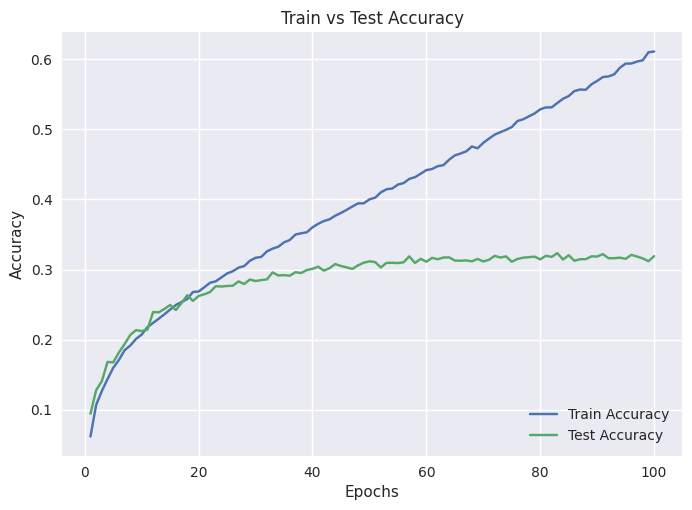

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 94.70it/s] 


####  Superclass confusion matrix

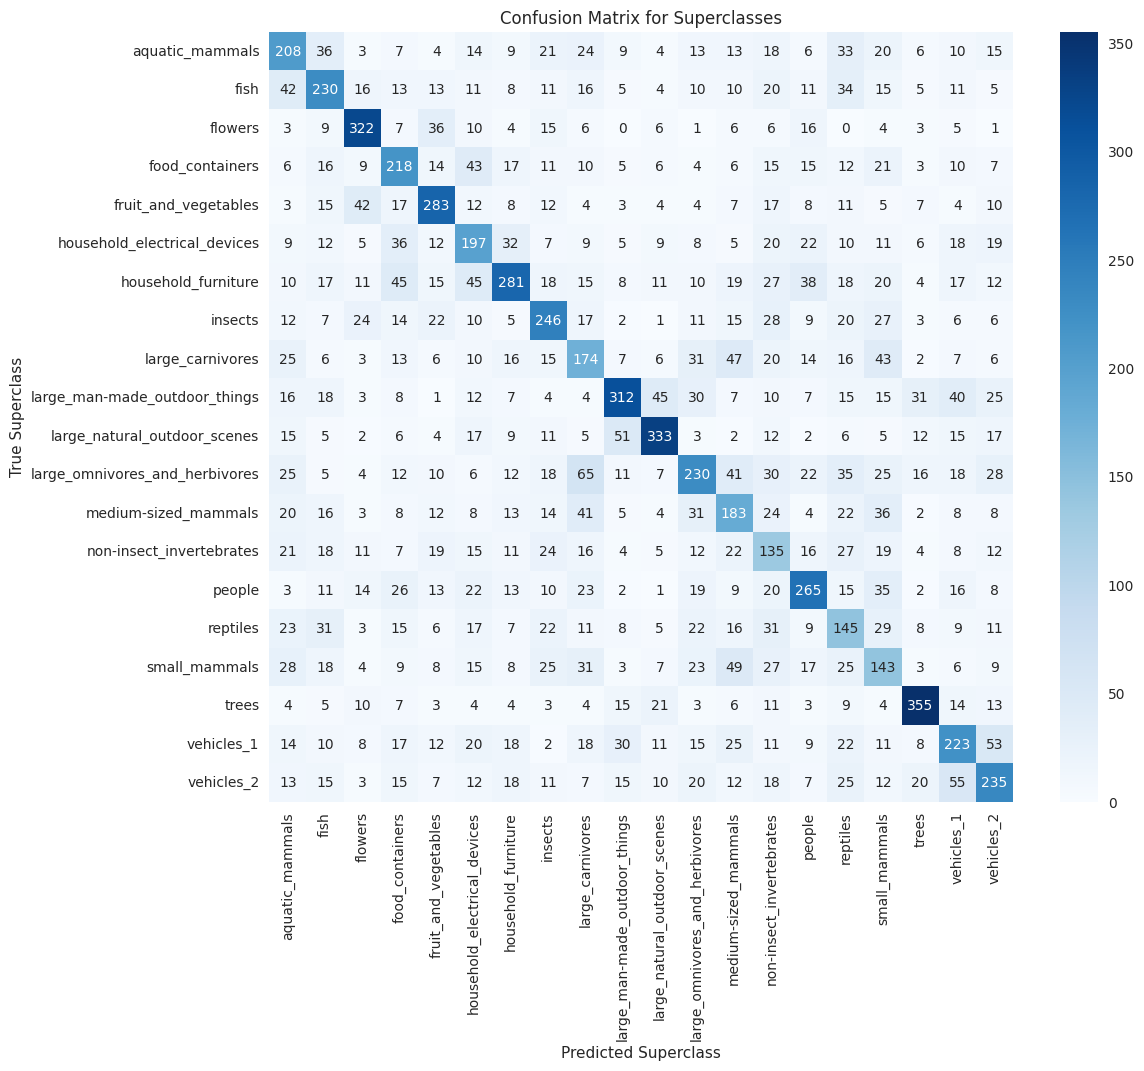

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

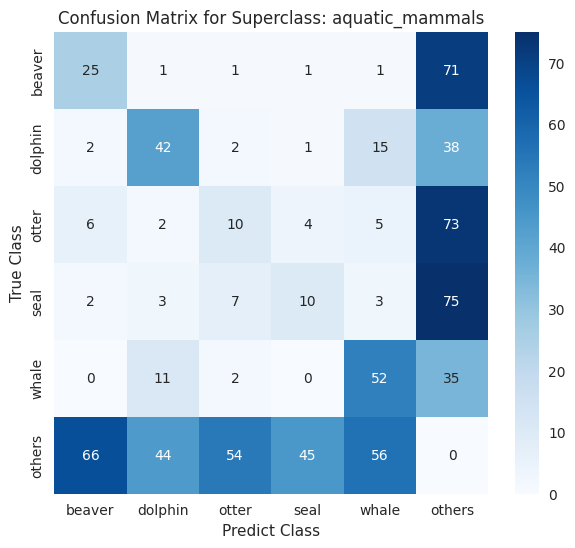

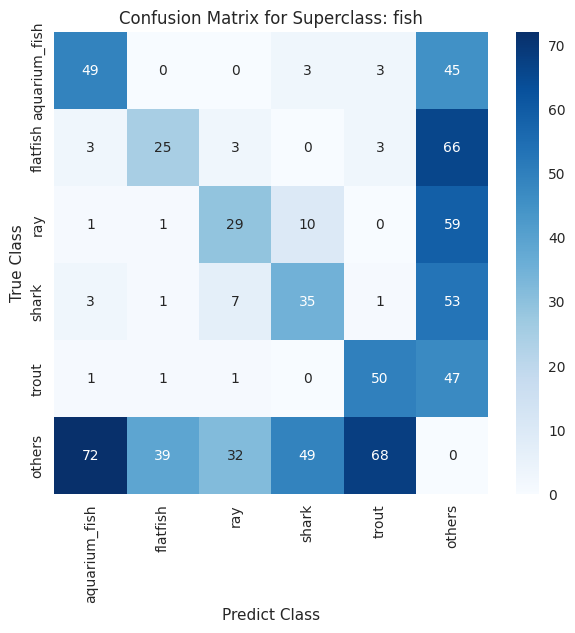

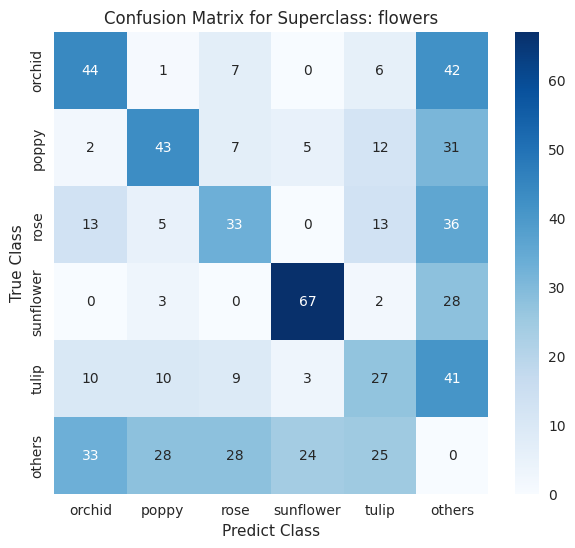

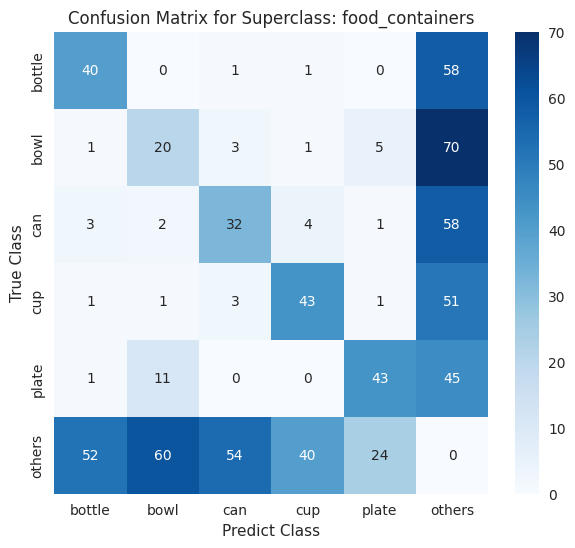

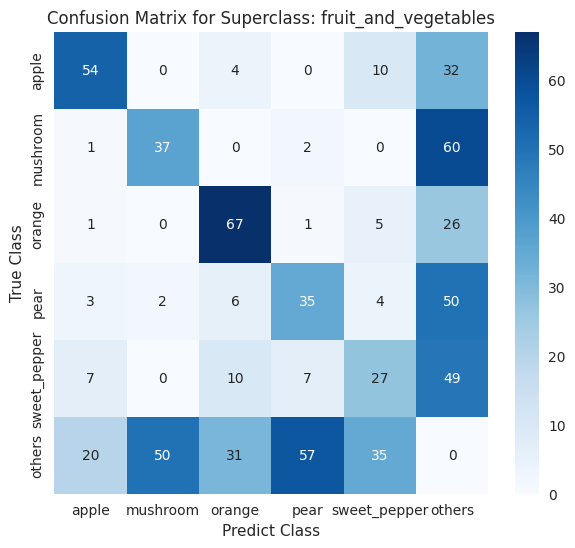

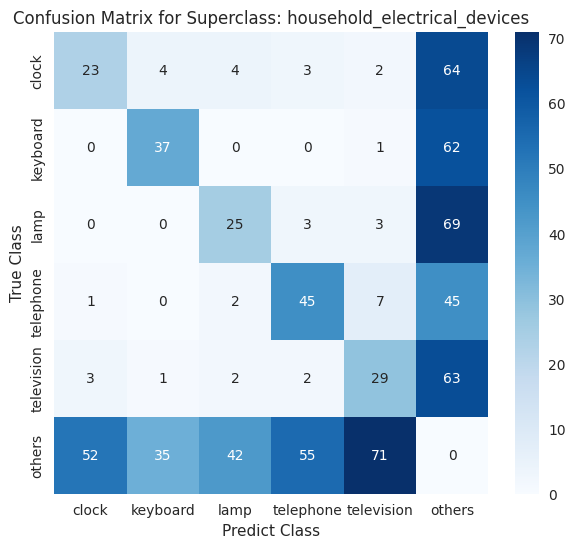

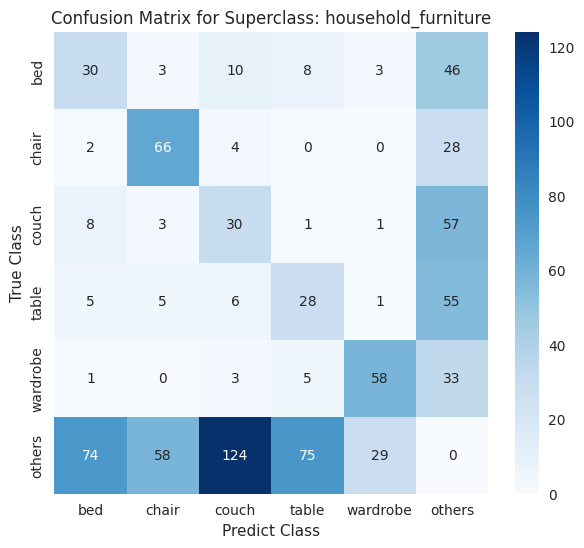

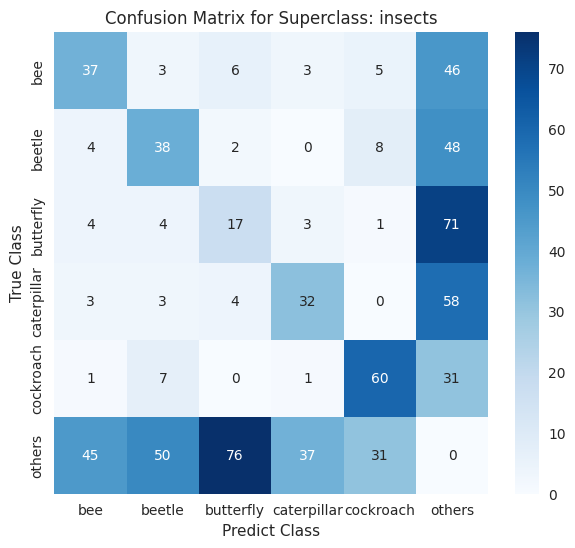

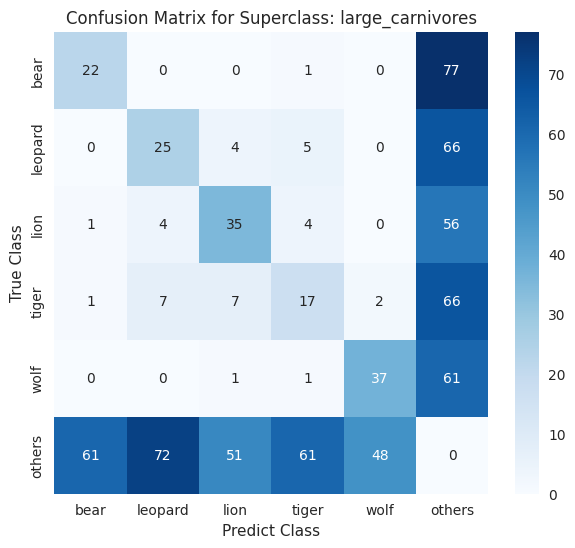

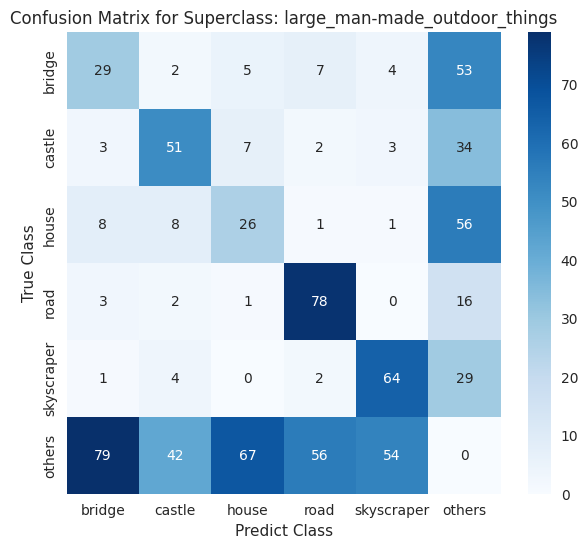

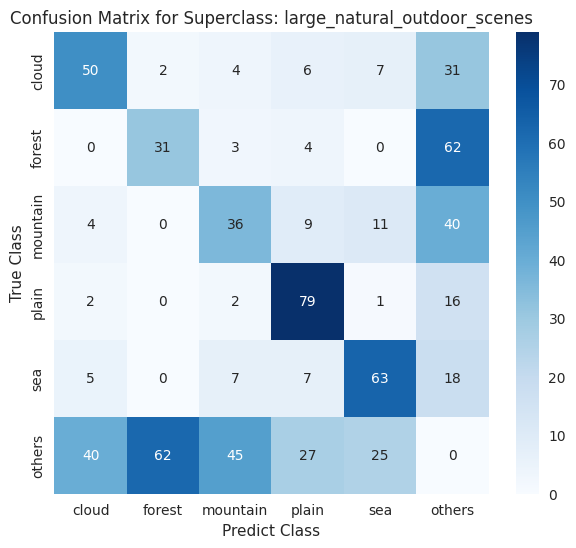

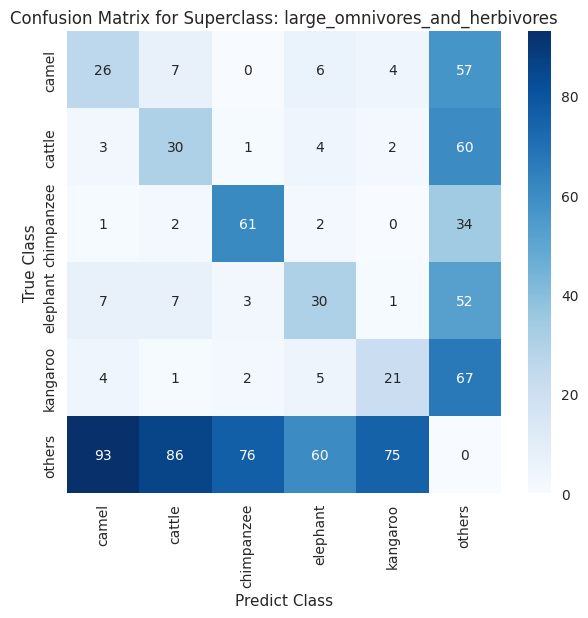

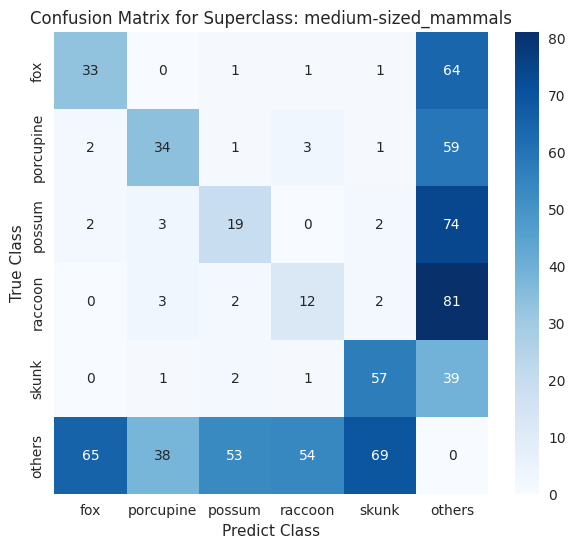

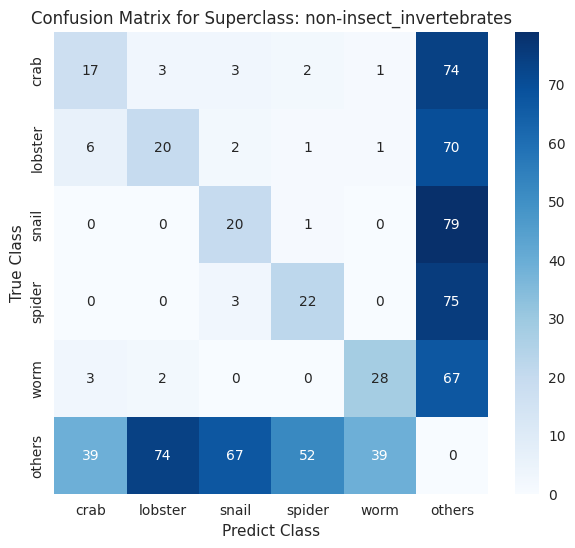

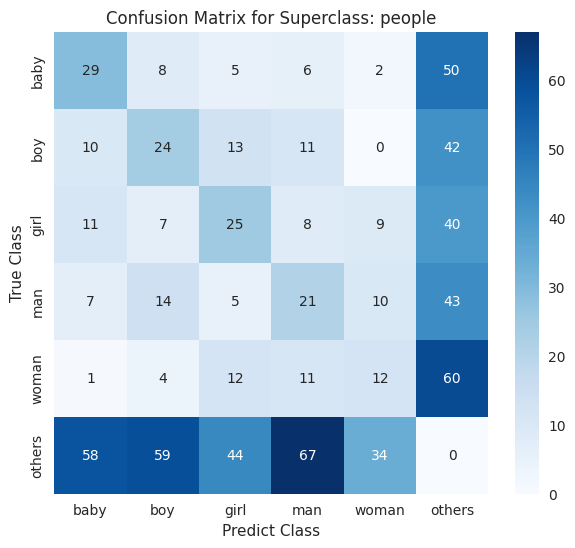

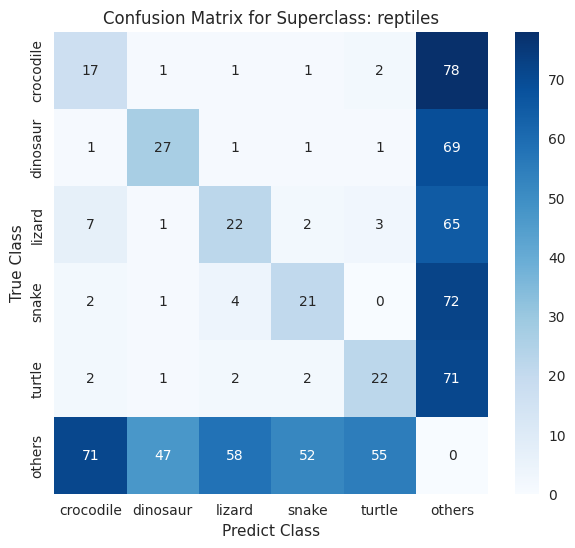

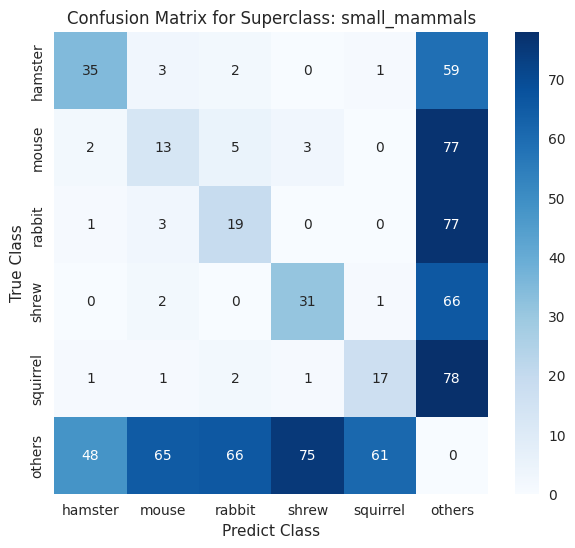

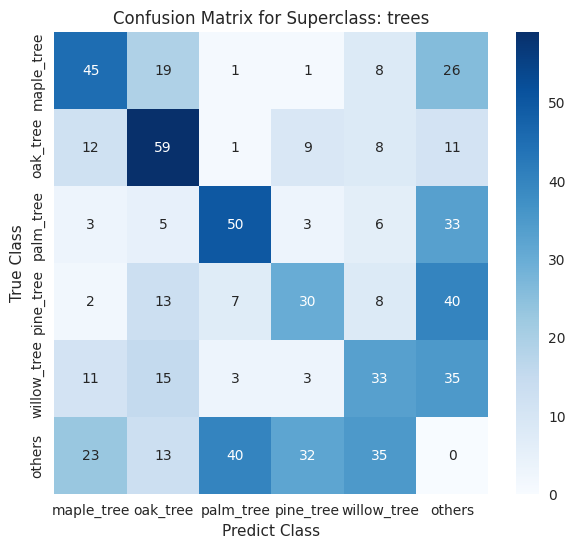

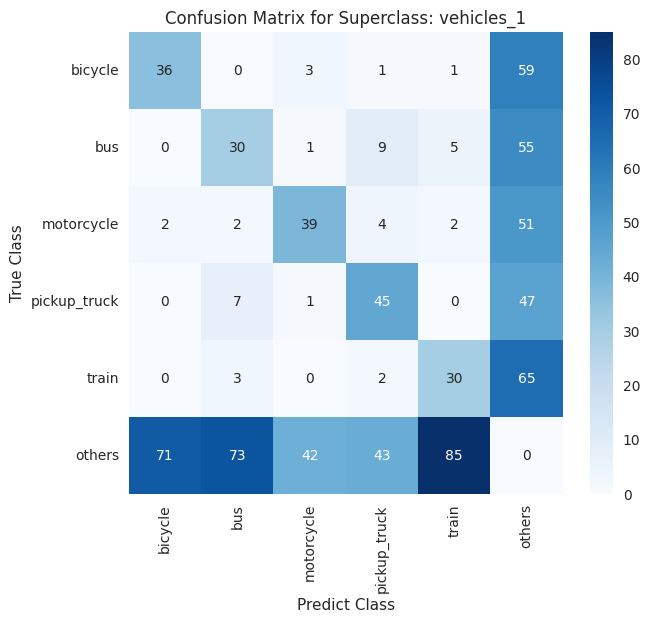

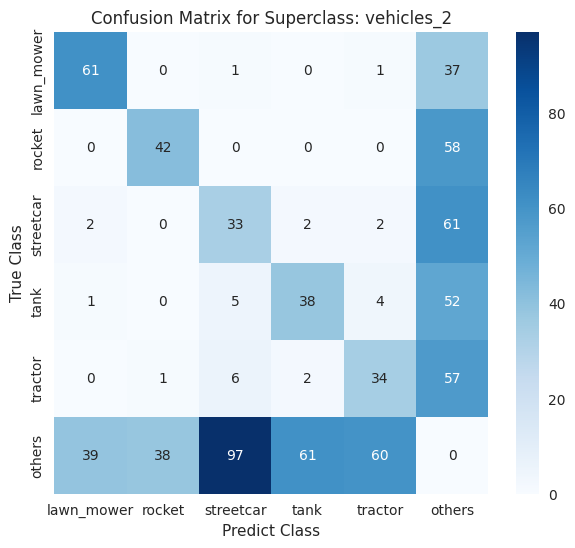

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("/kaggle/input/vit_v6/pytorch/default/1/VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  36.47 M 
fwd MACs:                                                               5.7632 GMACs
fwd FLOPs:                                                              11.5427 GFLOPS
fwd+bwd MACs:                                                           17.2897 GMACs
fwd+bwd FLOPs:                                                          34.6282 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod